In [24]:
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorly
from tensorly.decomposition import tucker
tensorly.set_backend('numpy')
import itertools
from sklearn.decomposition.pca import PCA
import string
import numpy as np
import pandas as pds
import os
import pickle
from ckine.tensor_generation import prepare_tensor
from ckine.figures.figureCommon import subplotLabel, getSetup, plot_timepoint, plot_cells, plot_ligands, plot_values
from ckine.Tensor_analysis import reorient_factors, z_score_values

Using numpy backend.


In [25]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
expr_filename = os.path.join(fileDir, './ckine/data/expr_table.csv')
data = pds.read_csv(expr_filename) # Every column in the data represents a specific cell
cell_names = data.columns.values.tolist()[1::] #returns the cell names from the pandas dataframe (which came from csv)

In [26]:
def plot_timepoints(ax, factors):
    """Function to put all timepoint plots in one figure."""
    ts = np.logspace(-3., np.log10(4 * 60.), 100)
    ts = np.insert(ts, 0, 0.0)
    colors = ['b', 'k', 'r', 'y', 'm', 'g']
    for ii in range(factors.shape[1]):
        ax.plot(ts, factors[:,ii], c = colors[ii], label = 'Component ' + str(ii+1))
        ax.scatter(ts[-1], factors[-1, ii], s = 12, color = 'k')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Component')
    ax.legend()

In [29]:
def makeFigure(values):
    """Get a list of the axis objects and create a figure"""
    # Get list of axis objects
    fileDir = os.path.dirname(os.path.realpath('__file__'))

    factors_filename = os.path.join(fileDir, './ckine/data/factors_results/Sampling.pickle')
    factors_filename = os.path.abspath(os.path.realpath(factors_filename))

    expr_filename = os.path.join(fileDir, './ckine/data/expr_table.csv')
    data = pds.read_csv(expr_filename) # Every column in the data represents a specific cell
    cell_names = data.columns.values.tolist()[1::] #returns the cell names from the pandas dataframe (which came from csv)

    n_time = 2
    n_cells = 9
    n_combos = 8
    n_values = 5

    out = tucker(z_score_values(values), ranks = [n_time,n_cells,n_combos,n_values], init = 'random')
    factors = out[1]
    newfactors = reorient_factors(factors)

    x, y = 4, 4
    ssize = 5
    ax, f = getSetup((ssize*y, ssize*x), (x, y))

    plot_timepoints(ax[0], newfactors[0])

    
    for row in range(x):
        subplotLabel(ax[row], string.ascii_uppercase[row]) # Add subplot labels
        compNum = 2*row + 1
        if row >= 1:
            ax[row*y].axis('off')

        if row > np.floor(n_values/3):
            ax[row*y +3].axis('off')

        plot_cells(ax[row*y + 1], newfactors[1], compNum, compNum+1, cell_names, ax_pos = row*y + 1)
        plot_ligands(ax[row*y + 2], newfactors[2], compNum, compNum+1)
        if row*y + 3 <= 7:
            plot_values(ax[row*y + 3] ,newfactors[3], compNum, compNum+1, ax_pos = row*y + 3)

        # Set axes to center on the origin, and add labels
        for col in range(1,y):
            ax[row*y + col].set_xlabel('Component ' + str(compNum))
            ax[row*y + col].set_ylabel('Component ' + str(compNum+1))

            x_max = np.max(np.absolute(np.asarray(ax[row*y + col].get_xlim())))*1.1
            y_max = np.max(np.absolute(np.asarray(ax[row*y + col].get_ylim())))*1.1

            ax[row*y + col].set_xlim(-x_max, x_max)
            ax[row*y + col].set_ylim(-y_max, y_max)

    return f

In [5]:
values, _, _, _, _ = prepare_tensor(2)
values = values[:,:,:,[0,1,2,3,4]]

100%|██████████| 2176/2176 [00:18<00:00, 119.93it/s]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

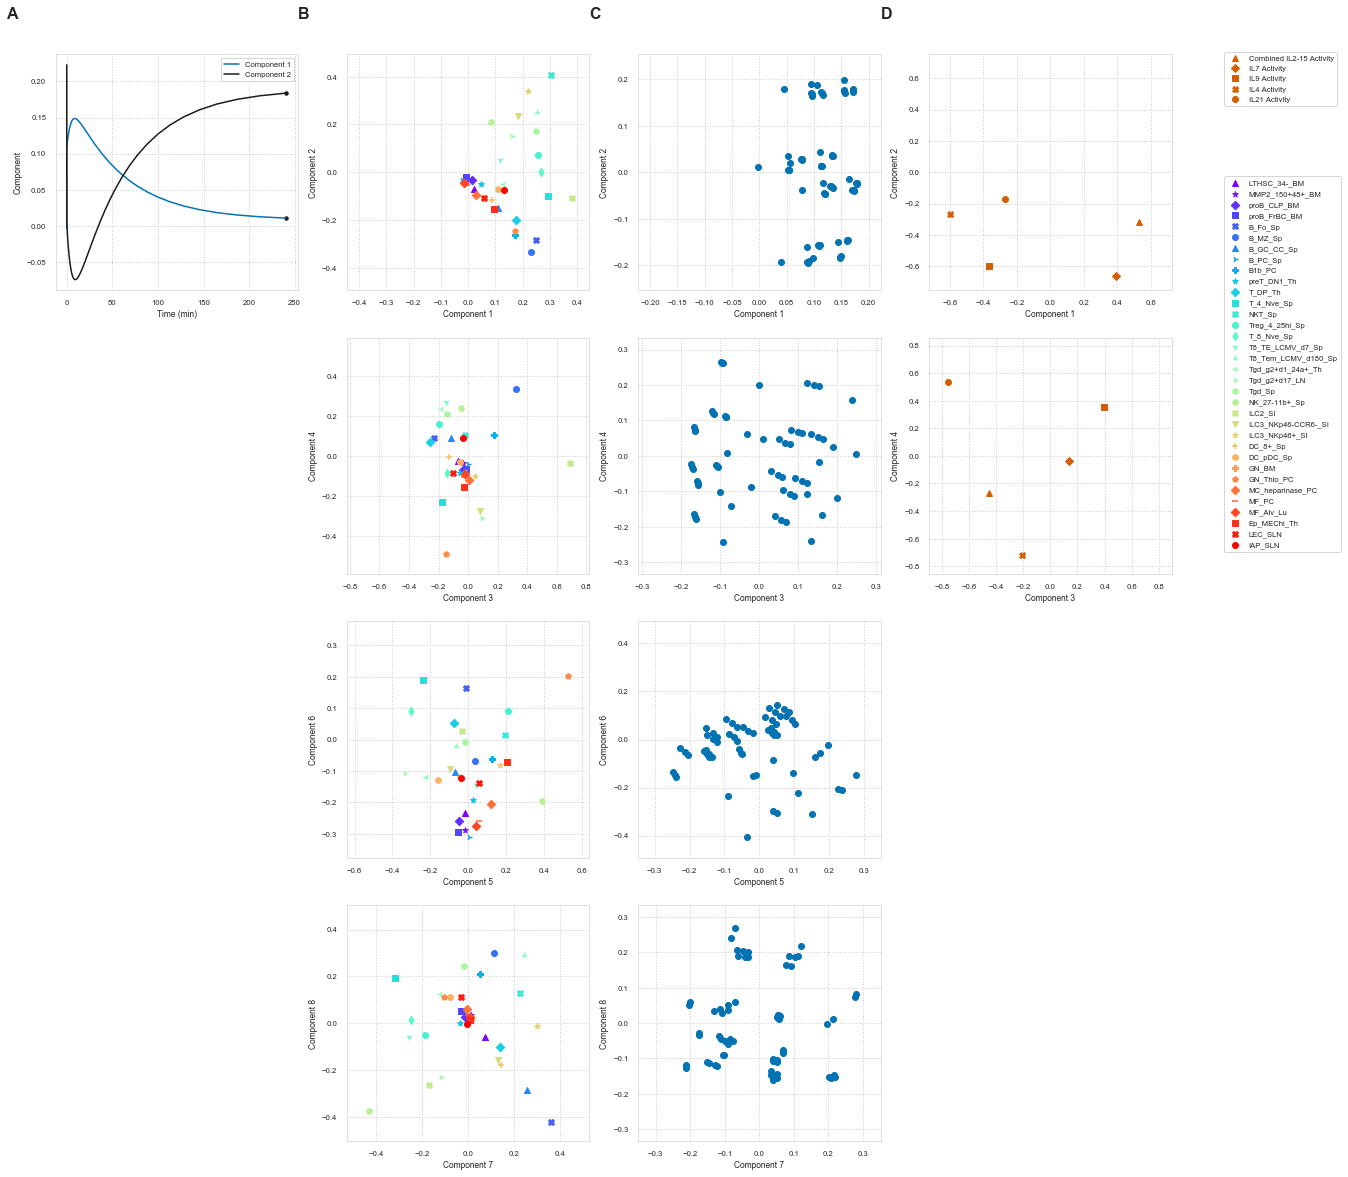

In [30]:
makeFigure(values);

In [31]:
def find_R2Xs(values, out, subt = True):
    '''Compute R2X'''
    z_values = z_score_values(values, subtract = subt)
    values_reconstructed = tensorly.tucker_tensor.tucker_to_tensor(out[0], out[1])
    return 1 - np.var(values_reconstructed - z_values) / np.var(z_values)

In [32]:
out1 = tucker(z_score_values(values), ranks = [2,9,8,5], init = 'random')
reconstructed = tensorly.tucker_to_tensor(out1[0], out1[1])
reconstructed.shape
R2X = find_R2Xs(values, out1)
R2X

0.9845963261672666